<a href="https://colab.research.google.com/github/brunogresende/ppca-aed/blob/main/Aloca%C3%A7%C3%A3o_de_Pessoas_em_Trabalho_Remoto_Scheduling_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
#!pip install -U pulp

from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpConstraint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [97]:
#Notations
n     = 20  #number of days for planning (20 = 1 month)
tAJr  = 20  #number of junior analysts
tASr  = 10  #number of senior analysts
tE    = 5   #number of specialists
max_day_team_absence = math.ceil((tAJr + tASr + tE)*0.3) #max absence allowed in team (30%), ceil rounding

#Decision variables
#Absences: 1 if day-off, 0 otherwise
var_LAJr = LpVariable.dicts("AbsenceAJr", (range(n), range(tAJr)), 0, 1, "Binary")
var_LASr = LpVariable.dicts("AbsenceASr", (range(n), range(tASr)), 0, 1, "Binary")
var_LE   = LpVariable.dicts("AbsenceEsp", (range(n), range(tE)), 0, 1, "Binary")

#Remote: 1 if remote work, 0 otherwise
var_AJr = LpVariable.dicts("RemoteAJr", (range(n), range(tAJr)), 0, 1, "Binary")
var_ASr = LpVariable.dicts("RemoteASr", (range(n), range(tASr)), 0, 1, "Binary")
var_E   = LpVariable.dicts("RemoteEsp", (range(n), range(tE)), 0, 1, "Binary")

#Objective function
obj = None
for i in range(n):
  for j in range(tE):
    obj += var_E[i][j]
    for jj in range(tAJr):
      obj += var_AJr[i][jj]
      for jjj in range(tASr):
        obj += var_ASr[i][jjj]

problem = LpProblem("Schedule", LpMaximize)
problem += obj

In [98]:
max_day_team_absence

11

In [99]:
#Constraint 0
#Absences configuration

#funci AJr 1, 0-5 dias de férias
for i in range(0,5):
  problem += var_LAJr[i][1] == 1

#funci ASr 0, 5-15 dias de férias
for i in range(5,15):
  problem += var_LASr[i][0] == 1

#funci AJr 5, 15-20 dias de férias
for i in range(15,20):
  problem += var_LAJr[i][5] == 1

#funci Esp 1, 3 dias de abono
for i in range(17,19):
  problem += var_LE[i][1] == 1

#funci AJr 10, 2 dias de abono
for i in range(3,5):
  problem += var_AJr[i][10] == 1

#funci ASr 1, 2 dias de abono
for i in range(4,6):
  problem += var_LASr[i][1] == 1


In [100]:
#Constraint 1
#Cada funcionário poderá estar trabalhando remoto (1), trabalhando no escritório (0) ou ausente (1), de forma excludente. 

c = None

for i in range(n):
  
  for j in range(tAJr):
    c = lpSum(var_AJr[i][j] + var_LAJr[i][j]) <= 1
    problem += c
    
  for jj in range(tASr):
    c = lpSum(var_ASr[i][jj] + var_LASr[i][jj]) <= 1
    problem += c
      
  for jjj in range(tE):
    c = lpSum(var_E[i][jjj] + var_LE[i][jjj]) <= 1
    problem += c 


In [101]:
#Constraint 2 
#Cada funcionário poderá ser alocado no máximo 8 dias em home-office no mês. 
for j in range(tAJr):
  c = None
  for i in range(n):
    c += var_AJr[i][j]
  problem += c <=8

for j in range(tASr):
  c = None
  for i in range(n):
    c += var_ASr[i][j]
  problem += c <=8

for j in range(tE):
  c = None
  for i in range(n):
    c += var_E[i][j]
  problem += c <=8


In [102]:
#Constraint 3
#A quantidade máxima de ausências do escritório deve ser 30% do total de funcionários da equipe. 

c = None
for i in range(n):
  for j in range(tAJr):
    c += var_AJr[i][j] + var_LAJr[i][j]

  for jj in range(tASr):
    c += var_ASr[i][jj] + var_LASr[i][jj]

  for jjj in range(tE):
    c += var_E[i][jjj] + var_LE[i][jjj]

problem += (c <= max_day_team_absence*n)

In [103]:
#Constraint 4
#Pelo menos um Especialista deve estar presente no escritório em um dia de trabalho

for i in range(n):
  c = None
  for j in range(tE):
    c += var_E[i][j] + var_LE[i][j]
  problem += (c <= tE-1)


In [104]:
#Constraint 5
#De forma a manter a interação entre o time, todos os colegas devem estar no escritório às quartas-feiras, exceto ausências planejadas.

for i in range(2,n,5):
  c = None
  for j in range(tAJr):
    c += var_AJr[i][j] 

  for jj in range(tASr):
    c += var_ASr[i][jj] 

  for jjj in range(tE):
    c += var_E[i][jjj] 

  problem += (c == 0)

In [105]:
#See the modeled problem
#problem

In [106]:
# Solve the problem

status = problem.solve()

# Print results
print(f"Solution Time: {problem.solutionTime}")
print(f"Solution CPU Time: {problem.solutionCpuTime}")
print(f"Status: {problem.status}, {LpStatus[problem.status]}")
print(f"Objective: {problem.objective.value()}")


Solution Time: 0.06005430221557617
Solution CPU Time: 0.062000000005355105
Status: 1, Optimal
Objective: 8580.0


In [107]:
# Initialize Matrix with zeros
matAJr = np.array([0]*n*tAJr).reshape(n,tAJr)
matASr = np.array([0]*n*tASr).reshape(n,tASr)
matEsp = np.array([0]*n*tE).reshape(n,tE)

for var in problem.variables():
    m = var.name.split("_")
    if "AJr" in m[0] and var.value() == 1:
        if "Absence" in m[0]:
            matAJr[int(m[1])][int(m[2])] = -1
        else:
            matAJr[int(m[1])][int(m[2])] = 1 
    if "ASr" in m[0] and var.value() == 1:
        if "Absence" in m[0]:
            matASr[int(m[1])][int(m[2])] = -1
        else:
            matASr[int(m[1])][int(m[2])] = 1
    if "Esp" in m[0] and var.value() == 1:
        if "Absence" in m[0]:
            matEsp[int(m[1])][int(m[2])] = -1
        else:
            matEsp[int(m[1])][int(m[2])] = 1

#pmatAJr = pd.DataFrame(matAJr)
#pmatASr = pd.DataFrame(matASr)
#pmatEsp = pd.DataFrame(matEsp)  

matrix = np.concatenate((matAJr,matASr,matEsp), axis=1)
#pmatrix = pd.DataFrame(matrix)

#print(matrix)
#print(pmatrix)

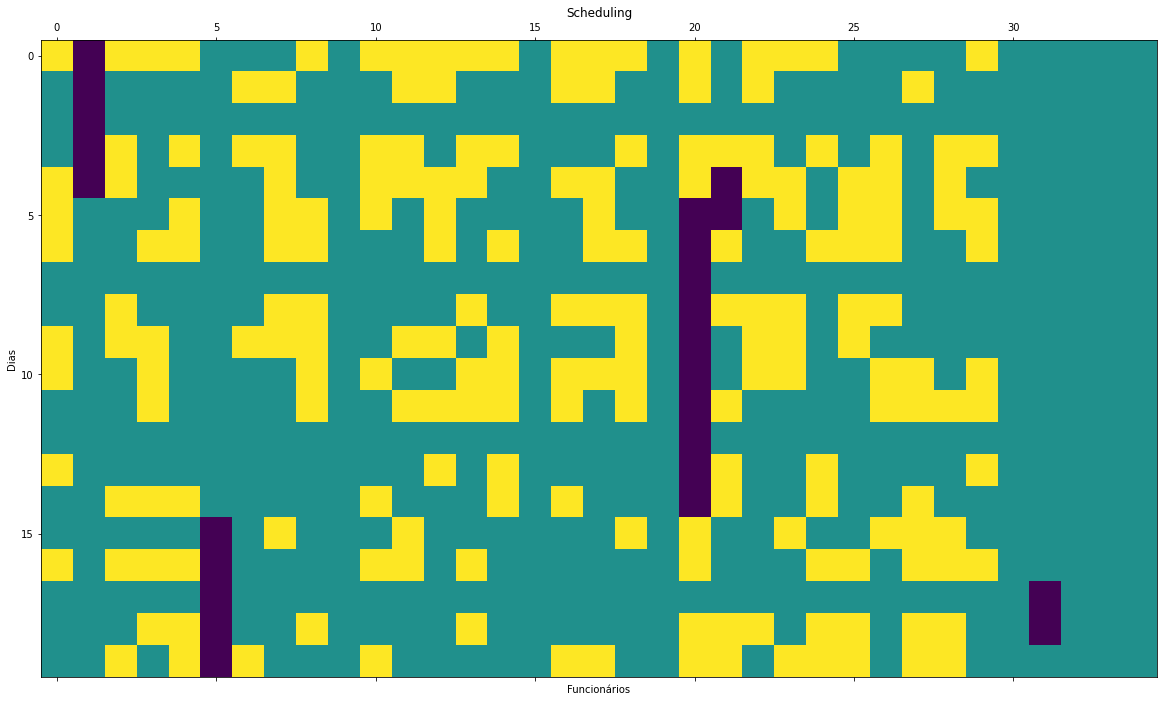

In [108]:
fig = plt.figure(figsize=(20,15))

# Creating subplot/axes
ax = fig.add_subplot()

# Setting axes/plot title
ax.set_title('Scheduling')

# Setting X-axis and Y-axis labels
ax.set_ylabel('Dias')
ax.set_xlabel('Funcionários', )

ax.matshow(matrix)

# Showing the plot
plt.show()

In [109]:
#sns.clustermap(matrix)

In [110]:
#for var in problem.variables():
#    print(f"{var.name}: {var.value()}")

#for name, constraint in problem.constraints.items():
#    print(f"{name}: {constraint.value()}")